## Project 6

In [3]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import scipy
import requests
from imdbpie import Imdb
import nltk
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
import nltk
import collections
import re
import csv
import psycopg2

%matplotlib inline

### Pre-Work: Write a problem statement 

## Part 1: Acquire the Data

#### 1. Connect to the IMDB API

In [4]:
imdb = Imdb()
imdb = Imdb(anonymize=True)

#### 2. Query the top 250 rated movies in the database

In [5]:
'''
Creating a dataframe of the Top 250 movies.
'''
top_250 = pd.DataFrame(imdb.top_250())
top_250.head()

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1678989,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1148746,9.2,tt0068646,The Godfather,feature,1972
2,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,785572,9.0,tt0071562,The Godfather: Part II,feature,1974
3,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1664146,9.0,tt0468569,The Dark Knight,feature,2008
4,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,859314,8.9,tt0108052,Schindler's List,feature,1993


In [6]:
top_250.type.value_counts()

feature    250
Name: type, dtype: int64

In [7]:
top_250.can_rate.value_counts()

True    250
Name: can_rate, dtype: int64

In [8]:
del top_250['type']
del top_250['can_rate']
del top_250['image']

In [9]:
top_250.head()

,num_votes,rating,tconst,title,year
0,1678989,9.3,tt0111161,The Shawshank Redemption,1994
1,1148746,9.2,tt0068646,The Godfather,1972
2,785572,9.0,tt0071562,The Godfather: Part II,1974
3,1664146,9.0,tt0468569,The Dark Knight,2008
4,859314,8.9,tt0108052,Schindler's List,1993


#### 3. Only select the top 25 movies and delete the uncessary rows

In [10]:
df = top_250.head(25)
df.shape

(25, 5)

In [87]:
df.head()

,num_votes,rating,tconst,title,year
0,1678989,9.3,tt0111161,The Shawshank Redemption,1994
1,1148746,9.2,tt0068646,The Godfather,1972
2,785572,9.0,tt0071562,The Godfather: Part II,1974
3,1664146,9.0,tt0468569,The Dark Knight,2008
4,859314,8.9,tt0108052,Schindler's List,1993


#### 4. Write the Results to a csv

In [11]:
!pwd

/Users/isaacmoore/Google Drive/data_science/general_assembly/Projects/DSI_SM_Project6


In [12]:
df.to_csv('imdb_top25.csv', encoding='utf-8')

In [13]:
!ls

Untitled.ipynb            project6-isaacmoore.ipynb reviews_bacup.csv
imdb_top25.csv            readme.md                 reviews_bacup2.csv


## Part 2: Wrangle the text data

#### 1. Convert the listing identification numbers (tconst) from the first dataframe to a list

In [14]:
ids = df.tconst.values
ids[:5]

array([u'tt0111161', u'tt0068646', u'tt0071562', u'tt0468569', u'tt0108052'], dtype=object)

#### 2. Scrape the reviews for the top 25 movies

*Hint*: Use a loop to scrape each page at once

In [18]:
# Smaller Dataset for Testing
reviews_raw = {}
for i in ids:
        reviews_raw[i] = imdb.get_title_reviews(str(i), max_results=25)

In [19]:
reviews_raw

{u'tt0038650': [<Review: u"Honestly, I don't th">,
  <Review: u'\nI am a film lover f'>,
  <Review: u'\nNo movie ever made '>,
  <Review: u'\n\nThis film has beco'>,
  <Review: u'\nAfter strong perfor'>,
  <Review: u'I am so glad Frank C'>,
  <Review: u'\nThis is one of the '>,
  <Review: u"\nHere's a new defini">,
  <Review: u"I've always thought ">,
  <Review: u'\nNo other film comes'>,
  <Review: u'Review edited and th'>,
  <Review: u'When I heard about t'>,
  <Review: u'\nI just re-watched t'>,
  <Review: u'George Bailey is a m'>,
  <Review: u"I once read that It'">,
  <Review: u"Criticizing It's A W">,
  <Review: u'On one crisp Decembe'>,
  <Review: u'The premise of the s'>,
  <Review: u'My apologies to all '>,
  <Review: u'I had fond memories '>,
  <Review: u'There are movies tha'>,
  <Review: u'\nBefore writing my c'>,
  <Review: u'\nNo folks, I promise'>,
  <Review: u'I know this is going'>,
  <Review: u'The first time I am '>],
 u'tt0047478': [<Review: u'\nThe archetypal acti'

# TEST FROM HERE!

In [60]:
reviews_clean = pd.DataFrame(reviews_raw).transpose()
reviews_clean.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
tt0038650,"<Review: Honestly, I don't th>",<Review: \nI am a film lover f>,<Review: \nNo movie ever made >,<Review: \n\nThis film has beco>,<Review: \nAfter strong perfor>,<Review: I am so glad Frank C>,<Review: \nThis is one of the >,<Review: \nHere's a new defini>,<Review: I've always thought >,<Review: \nNo other film comes>,...,<Review: Criticizing It's A W>,<Review: On one crisp Decembe>,<Review: The premise of the s>,<Review: My apologies to all >,<Review: I had fond memories >,<Review: There are movies tha>,<Review: \nBefore writing my c>,"<Review: \nNo folks, I promise>",<Review: I know this is going>,<Review: The first time I am >
tt0047478,<Review: \nThe archetypal acti>,<Review: \nAkira Kurosawa's ma>,<Review: I discovered 16 of K>,"<Review: \nIn 1954, Kurosawa m>",<Review: \nHaving seen Kurosaw>,"<Review: Well, if you haven't>",<Review: \nStory-telling at it>,<Review: Though its biblical >,<Review: Akira Kurosawa was a>,<Review: \nThis is one of thos>,...,<Review: Excuse me first The >,<Review: Much has been said h>,<Review: I really like this m>,<Review: In the Sixteenth Cen>,<Review: The great Akira Kuro>,"<Review: Its sad really, sad >",<Review: I had the pleasure t>,<Review: \nAll I have to say i>,<Review: \nThis flick has ever>,"<Review: For what it is, this>"
tt0050083,<Review: \nAn excellent courtr>,<Review: \nThis film is superb>,<Review: '12 Angry Men' is an>,<Review: ........Films rarely>,<Review: This film deserves t>,<Review: I watched this film >,<Review: \nThis once-in-a-gene>,<Review: \nThis is one of thos>,<Review: \nThe plot of12 Angry>,<Review: \nIntense courtroom d>,...,<Review: Some movies are not >,<Review: It's tough sometimes>,<Review: (Spoilers) I really >,<Review: Having seen the film>,<Review: \nWhat a bloody stupi>,<Review: This is one of the g>,"<Review: Juror #1, the forema>",<Review: When I was younger I>,"<Review: And that what I did,>","<Review: (January,2006) I'll >"
tt0060196,<Review: \nA sprawling Western>,"<Review: \nThis is the third,a>",<Review: \nThis is without a d>,"<Review: \nOk- first, as menti>",<Review: I wasn't sure if I w>,<Review: \noften overlooked or>,<Review: On a partial first v>,<Review: \nThis film probably >,<Review: \nRather than a revie>,<Review: ...and though those >,...,<Review: \nBelfast-based comic>,<Review: \nSergio Leone is arg>,<Review: Sergio Leone always >,<Review: \nSpoilers herein.\n\nT>,<Review: I know some movie fa>,<Review: This is one of the f>,<Review: In New Mexico Territ>,"<Review: The Good, the Bad an>",<Review: \nSergio Leone is an >,<Review: The basic plot of TH>
tt0068646,<Review: Rather than concentr>,<Review: \nThis is by far the >,<Review: \nThe Godfather is on>,<Review: \n This movie is >,<Review: \nThe Godfather is on>,<Review: This is a masterpiec>,<Review: This must rank as th>,<Review: 'The Godfather' is t>,<Review: I love this movie an>,<Review: The godfather trilog>,...,<Review: Tell me a movie that>,<Review: I can remember when >,<Review: \nMichael Corleone re>,<Review: Some people have cal>,<Review: The Godfather is an >,<Review: \nOne thing that's a >,<Review: \nFirst I have to say>,<Review: Spoilers Ahead;\n\nI a>,<Review: Think epic novel cro>,<Review: Marlon Brando's acti>


In [61]:
reviews_clean.columns = ['review_1','review_2','review_3','review_4','review_5','review_6','review_7','review_8','review_9',
                'review_10','review_11','review_12','review_13','review_14','review_15','review_16','review_17',
                'review_18','review_19','review_20','review_21','review_22','review_23','review_24','review_25']
reviews_clean.head()

,review_1,review_2,review_3,review_4,review_5,review_6,review_7,review_8,review_9,review_10,...,review_16,review_17,review_18,review_19,review_20,review_21,review_22,review_23,review_24,review_25
tt0038650,"<Review: Honestly, I don't th>",<Review: \nI am a film lover f>,<Review: \nNo movie ever made >,<Review: \n\nThis film has beco>,<Review: \nAfter strong perfor>,<Review: I am so glad Frank C>,<Review: \nThis is one of the >,<Review: \nHere's a new defini>,<Review: I've always thought >,<Review: \nNo other film comes>,...,<Review: Criticizing It's A W>,<Review: On one crisp Decembe>,<Review: The premise of the s>,<Review: My apologies to all >,<Review: I had fond memories >,<Review: There are movies tha>,<Review: \nBefore writing my c>,"<Review: \nNo folks, I promise>",<Review: I know this is going>,<Review: The first time I am >
tt0047478,<Review: \nThe archetypal acti>,<Review: \nAkira Kurosawa's ma>,<Review: I discovered 16 of K>,"<Review: \nIn 1954, Kurosawa m>",<Review: \nHaving seen Kurosaw>,"<Review: Well, if you haven't>",<Review: \nStory-telling at it>,<Review: Though its biblical >,<Review: Akira Kurosawa was a>,<Review: \nThis is one of thos>,...,<Review: Excuse me first The >,<Review: Much has been said h>,<Review: I really like this m>,<Review: In the Sixteenth Cen>,<Review: The great Akira Kuro>,"<Review: Its sad really, sad >",<Review: I had the pleasure t>,<Review: \nAll I have to say i>,<Review: \nThis flick has ever>,"<Review: For what it is, this>"
tt0050083,<Review: \nAn excellent courtr>,<Review: \nThis film is superb>,<Review: '12 Angry Men' is an>,<Review: ........Films rarely>,<Review: This film deserves t>,<Review: I watched this film >,<Review: \nThis once-in-a-gene>,<Review: \nThis is one of thos>,<Review: \nThe plot of12 Angry>,<Review: \nIntense courtroom d>,...,<Review: Some movies are not >,<Review: It's tough sometimes>,<Review: (Spoilers) I really >,<Review: Having seen the film>,<Review: \nWhat a bloody stupi>,<Review: This is one of the g>,"<Review: Juror #1, the forema>",<Review: When I was younger I>,"<Review: And that what I did,>","<Review: (January,2006) I'll >"
tt0060196,<Review: \nA sprawling Western>,"<Review: \nThis is the third,a>",<Review: \nThis is without a d>,"<Review: \nOk- first, as menti>",<Review: I wasn't sure if I w>,<Review: \noften overlooked or>,<Review: On a partial first v>,<Review: \nThis film probably >,<Review: \nRather than a revie>,<Review: ...and though those >,...,<Review: \nBelfast-based comic>,<Review: \nSergio Leone is arg>,<Review: Sergio Leone always >,<Review: \nSpoilers herein.\n\nT>,<Review: I know some movie fa>,<Review: This is one of the f>,<Review: In New Mexico Territ>,"<Review: The Good, the Bad an>",<Review: \nSergio Leone is an >,<Review: The basic plot of TH>
tt0068646,<Review: Rather than concentr>,<Review: \nThis is by far the >,<Review: \nThe Godfather is on>,<Review: \n This movie is >,<Review: \nThe Godfather is on>,<Review: This is a masterpiec>,<Review: This must rank as th>,<Review: 'The Godfather' is t>,<Review: I love this movie an>,<Review: The godfather trilog>,...,<Review: Tell me a movie that>,<Review: I can remember when >,<Review: \nMichael Corleone re>,<Review: Some people have cal>,<Review: The Godfather is an >,<Review: \nOne thing that's a >,<Review: \nFirst I have to say>,<Review: Spoilers Ahead;\n\nI a>,<Review: Think epic novel cro>,<Review: Marlon Brando's acti>


In [62]:
for num in range(1,len(reviews_clean.columns)+1):
    review_clean_temp = []
    for i in eval('reviews_clean.review_'+str(num)):
        review_clean_temp.append(i.text)
    reviews_clean['review_'+str(num)] = review_clean_temp
reviews_clean.head()

,review_1,review_2,review_3,review_4,review_5,review_6,review_7,review_8,review_9,review_10,...,review_16,review_17,review_18,review_19,review_20,review_21,review_22,review_23,review_24,review_25
tt0038650,"Honestly, I don't think I've ever seen anythin...","\nI am a film lover from 'way back, having eve...",\nNo movie ever made has influenced me more th...,\n\nThis film has become a Christmas tradition...,"\nAfter strong performances in films such as ""...",I am so glad Frank Capra had a vision to make ...,"\nThis is one of the best films of all time, w...",\nHere's a new definition of cold-hearted: a m...,I've always thought that the reason It's A Won...,\nNo other film comes anywhere near to getting...,...,Criticizing It's A Wonderful Life is almost an...,"On one crisp December evening, two decades ago...","The premise of the story is, of course, how a ...","My apologies to all of you ""It's a Wonderful L...","I had fond memories of ""It's A Wonderful Life""...",There are movies that we like so much we will ...,"\nBefore writing my comment, I skimmed through...","\nNo folks, I promise not to do the same thing...","I know this is going to sound ridicules, but s...",The first time I am aware of seeing IAWL I man...
tt0047478,"\nThe archetypal action film, Seven Samurai is...",\nAkira Kurosawa's masterpiece... The Japanese...,I discovered 16 of Kurosawa's best known films...,"\nIn 1954, Kurosawa made foreign film history ...",\nHaving seen Kurosawa's Seven Samurai at leas...,"Well, if you haven't seen Seven Samurai then y...","\nStory-telling at its finest, ""Seven Samurai""...",Though its biblical connotation is not the hap...,Akira Kurosawa was and is considered the maste...,\nThis is one of those great epic films that s...,...,Excuse me first The English is not my first la...,Much has been said here about why would anyone...,I really like this movie and have seen it seve...,"In the Sixteenth Century, in Japan, a poor vil...",The great Akira Kurosawa's epic action masterp...,"Its sad really, sad the way teens with their p...",I had the pleasure to see this film in America...,\nAll I have to say is that I first saw this m...,\nThis flick has everything. Drama. Comedy. ...,"For what it is, this film is good, but is also..."
tt0050083,\nAn excellent courtroom drama with a unique t...,"\nThis film is superb, in fact as Shakespeare ...",'12 Angry Men' is an outstanding film. It is p...,........Films rarely get this uplifting and br...,This film deserves to be on anyone's list of t...,"I watched this film for the first time, when i...",\nThis once-in-a-generation masterpiece simply...,\nThis is one of those movies where everything...,\nThe plot of12 Angry Men revolves around the ...,\nIntense courtroom drama which has 12 very di...,...,Some movies are not for certain period of time...,It's tough sometimes to translate a stage prod...,(Spoilers) I really liked the message of the m...,"Having seen the film before, we decided to tak...",\nWhat a bloody stupid idea for a cinema film ...,This is one of the greatest films ever made......,"Juror #1, the foreman (Martin Balsam, football...",When I was younger I thought 12 Angry Men was ...,"And that what I did, I friend of mine has been...","(January,2006) I'll start by saying that if th..."
tt0060196,\nA sprawling Western epic that follows the ad...,"\nThis is the third,and arguably the best, of ...",\nThis is without a doubt my all-time favorite...,"\nOk- first, as mentioned in another review, t...",I wasn't sure if I was going to comment on thi...,"\noften overlooked or belittled by so-called ""...","On a partial first viewing, I didn't like ""The...",\nThis film probably had the largest impact on...,"\nRather than a review of a 30 year old movie,...",...and though those last several words could a...,...,\nBelfast-based comics writer Garth Ennis said...,\nSergio Leone is arguably the most visionary ...,Sergio Leone always wanted every picture he ma...,\nSpoilers herein.\n\nThis film re

In [63]:
reviews_clean.ix[0,0]

u"Honestly, I don't think I've ever seen anything quite like It's A Wonderful Life. \n\nDoes it take me back to that place in my heart, that makes me long for everything that once was great and it could be again? Does it remind me of my childhood, Christmas in my home? No. Maybe it's just simply what I always wanted from life and every man I want to be. \n\nEverything about this film is well for lack of better words, perfect. No question to it any longer, the best performance by an actor I have ever seen. It's more than just beautiful, timeless or fair. All of Stewart is revealed. Everything coming together for Capra. Lionel Barrymore at his best, which seems to be his worst. \n\nSometimes I think there is a reason why somethings happen. And I'm pretty sure there is some magical reason why this film was made. I'm 27 years old and saw it for the first time Christmas Eve of this year. I've watched it 3 times since. The only movie to ever make me cry. I probably wouldn't have all the answ

In [64]:
import re

for num in range(1,len(reviews_clean.columns)+1):
    reviews_clean_temp = []
    for i in eval('reviews_clean.review_'+str(num)):
        reviews_clean_temp.append(re.sub(r"[^a-zA-Z0-9 ]", "", i))
    reviews_clean['review_'+str(num)] = reviews_clean_temp
reviews_clean.head()

,review_1,review_2,review_3,review_4,review_5,review_6,review_7,review_8,review_9,review_10,...,review_16,review_17,review_18,review_19,review_20,review_21,review_22,review_23,review_24,review_25
tt0038650,Honestly I dont think Ive ever seen anything q...,I am a film lover from way back having even se...,No movie ever made has influenced me more than...,This film has become a Christmas tradition in ...,After strong performances in films such as Mr ...,I am so glad Frank Capra had a vision to make ...,This is one of the best films of all time with...,Heres a new definition of coldhearted a man or...,Ive always thought that the reason Its A Wonde...,No other film comes anywhere near to getting p...,...,Criticizing Its A Wonderful Life is almost an ...,On one crisp December evening two decades ago ...,The premise of the story is of course how a ma...,My apologies to all of you Its a Wonderful Lif...,I had fond memories of Its A Wonderful Life bu...,There are movies that we like so much we will ...,Before writing my comment I skimmed through th...,No folks I promise not to do the same thing to...,I know this is going to sound ridicules but se...,The first time I am aware of seeing IAWL I man...
tt0047478,The archetypal action film Seven Samurai is al...,Akira Kurosawas masterpiece The Japanese equiv...,I discovered 16 of Kurosawas best known films ...,In 1954 Kurosawa made foreign film history wit...,Having seen Kurosawas Seven Samurai at least 1...,Well if you havent seen Seven Samurai then you...,Storytelling at its finest Seven Samurai is a ...,Though its biblical connotation is not the hap...,Akira Kurosawa was and is considered the maste...,This is one of those great epic films that sta...,...,Excuse me first The English is not my first la...,Much has been said here about why would anyone...,I really like this movie and have seen it seve...,In the Sixteenth Century in Japan a poor villa...,The great Akira Kurosawas epic action masterpi...,Its sad really sad the way teens with their po...,I had the pleasure to see this film in America...,All I have to say is that I first saw this mov...,This flick has everything Drama Comedy Acti...,For what it is this film is good but is also b...
tt0050083,An excellent courtroom drama with a unique twi...,This film is superb in fact as Shakespeare onc...,12 Angry Men is an outstanding film It is proo...,Films rarely get this uplifting and brilliant ...,This film deserves to be on anyones list of to...,I watched this film for the first time when it...,This onceinageneration masterpiece simply has ...,This is one of those movies where everything c...,The plot of12 Angry Men revolves around the mu...,Intense courtroom drama which has 12 very diff...,...,Some movies are not for certain period of time...,Its tough sometimes to translate a stage produ...,Spoilers I really liked the message of the mov...,Having seen the film before we decided to take...,What a bloody stupid idea for a cinema film A...,This is one of the greatest films ever madeper...,Juror 1 the foreman Martin Balsam football coa...,When I was younger I thought 12 Angry Men was ...,And that what I did I friend of mine has been ...,January2006 Ill start by saying that if theres...
tt0060196,A sprawling Western epic that follows the adve...,This is the thirdand arguably the best of the ...,This is without a doubt my alltime favorite we...,Ok first as mentioned in another review the ge...,I wasnt sure if I was going to comment on this...,often overlooked or belittled by socalled film...,On a partial first viewing I didnt like The Go...,This film probably had the largest impact on m...,Rather than a review of a 30 year old movie he...,and though those last several words could also...,...,Belfastbased comics writer Garth Ennis said it...,Sergio Leone is arguably the most visionary di...,Sergio Leone always wanted every picture he ma...,Spoilers hereinThis film revolves around three...,I know some movie fans who consider The Good t...,Th

In [65]:
reviews_clean.ix[0,0]

u'Honestly I dont think Ive ever seen anything quite like Its A Wonderful Life Does it take me back to that place in my heart that makes me long for everything that once was great and it could be again Does it remind me of my childhood Christmas in my home No Maybe its just simply what I always wanted from life and every man I want to be Everything about this film is well for lack of better words perfect No question to it any longer the best performance by an actor I have ever seen Its more than just beautiful timeless or fair All of Stewart is revealed Everything coming together for Capra Lionel Barrymore at his best which seems to be his worst Sometimes I think there is a reason why somethings happen And Im pretty sure there is some magical reason why this film was made Im 27 years old and saw it for the first time Christmas Eve of this year Ive watched it 3 times since The only movie to ever make me cry I probably wouldnt have all the answers for you if you asked me why Im still try

#### 3. Work through each title and find the most common descriptors

*Hint*: "soup" from BeautifulSoup is the html returned from all 25 pages. You'll need to either address each page individually or break them down by elements

In [66]:
reviews_clean.head(1)

,review_1,review_2,review_3,review_4,review_5,review_6,review_7,review_8,review_9,review_10,...,review_16,review_17,review_18,review_19,review_20,review_21,review_22,review_23,review_24,review_25
tt0038650,Honestly I dont think Ive ever seen anything q...,I am a film lover from way back having even se...,No movie ever made has influenced me more than...,This film has become a Christmas tradition in ...,After strong performances in films such as Mr ...,I am so glad Frank Capra had a vision to make ...,This is one of the best films of all time with...,Heres a new definition of coldhearted a man or...,Ive always thought that the reason Its A Wonde...,No other film comes anywhere near to getting p...,...,Criticizing Its A Wonderful Life is almost an ...,On one crisp December evening two decades ago ...,The premise of the story is of course how a ma...,My apologies to all of you Its a Wonderful Lif...,I had fond memories of Its A Wonderful Life bu...,There are movies that we like so much we will ...,Before writing my comment I skimmed through th...,No folks I promise not to do the same thing to...,I know this is going to sound ridicules but se...,The first time I am aware of seeing IAWL I man...


In [30]:
!pwd

/Users/isaacmoore/Google Drive/data_science/general_assembly/Projects/DSI_SM_Project6


In [67]:
reviews_clean_byid = reviews_clean.T
reviews_clean_byid.head(3)

,tt0038650,tt0047478,tt0050083,tt0060196,tt0068646,tt0071562,tt0073486,tt0076759,tt0080684,tt0099685,...,tt0114369,tt0114814,tt0120737,tt0133093,tt0137523,tt0167260,tt0167261,tt0317248,tt0468569,tt1375666
review_1,Honestly I dont think Ive ever seen anything q...,The archetypal action film Seven Samurai is al...,An excellent courtroom drama with a unique twi...,A sprawling Western epic that follows the adve...,Rather than concentrating on everything that i...,This movie is way to be good to be labelled a ...,I went into this film with the knowledge that ...,What made this the hugely successful triumph i...,The Empire Strikes Back is the best film in th...,As far back as I can remember Ive always wante...,...,The movie Se7en starring Brad Pitt Morgan Free...,Ah the Usual Suspects My personal favorite mov...,but oh was I thankful for it All through the m...,The story of a reluctant Christlike protagonis...,When I first saw the previews for this movie i...,Peter Jackson has done it He has created an a...,Peter Jackson truly outdid himself when creati...,Cidade de Deus seems to have a lot of praise o...,Weve been subjected to enormous amounts of hyp...,Id like to keep my review rather to the pointP...
review_2,I am a film lover from way back having even se...,Akira Kurosawas masterpiece The Japanese equiv...,This film is superb in fact as Shakespeare onc...,This is the thirdand arguably the best of the ...,This is by far the best movie ever to give a p...,The original Godfather is a brilliant work It ...,Jack Nicholson is a great actor No not a great...,Star wars made epic fantasy real For a generat...,It avoids having the standard shootemup ending...,If there was one word that I could use to desc...,...,Sevens quality puts it so far beyond most of t...,The Usual Suspects has received a lot of comme...,Star Wars has been dethroned Although George ...,Writing a review of The Matrix is a very hard ...,I am unfortunately not one of the faithful Chu...,Saying that this film starts where Two Towers ...,It seems ridiculous to want to add my own comm...,The film revolves around the City of God a fav...,Christopher Nolans second bundle of joy The Da...,What is the most resilient parasite An Idea Ye...
review_3,No movie ever made has influenced me more than...,I discovered 16 of Kurosawas best known films ...,12 Angry Men is an outstanding film It is proo...,This is without a doubt my alltime favorite we...,The Godfather is one of the few films in which...,You can count on one hand the movie sequels th...,The opening shot of ONE FLEW OVER THE CUCKOOS ...,Theres not much to say about this movie this i...,The Rebellion has struck an important blow to ...,Needs to be seen to be believed in one word pe...,...,Seldom does a film elucidate the culpability o...,One day in a bookshop I flipped through a book...,It is with no surprise that Peter Jacksons The...,The Matrixwhen I first heard about it I expect...,Fight Club is one of the most unique films I h...,I am I admit an unlikely convert to the religi...,The opening scene of The Two Towers provides a...,I knew nothing of this film before I saw it by...,I had the honor of watching TDK during a scree...,Usually I try to be careful with over hyping a...


In [68]:
reviews_clean_byid.ix[0,0]

u'Honestly I dont think Ive ever seen anything quite like Its A Wonderful Life Does it take me back to that place in my heart that makes me long for everything that once was great and it could be again Does it remind me of my childhood Christmas in my home No Maybe its just simply what I always wanted from life and every man I want to be Everything about this film is well for lack of better words perfect No question to it any longer the best performance by an actor I have ever seen Its more than just beautiful timeless or fair All of Stewart is revealed Everything coming together for Capra Lionel Barrymore at his best which seems to be his worst Sometimes I think there is a reason why somethings happen And Im pretty sure there is some magical reason why this film was made Im 27 years old and saw it for the first time Christmas Eve of this year Ive watched it 3 times since The only movie to ever make me cry I probably wouldnt have all the answers for you if you asked me why Im still try

#### 4. Convert to a string and remove the non AlphaNumeric characters

- alphanum
- lemmatize
- stemming

In [ ]:
from collections import Counter 
import re
cleaned = re.compile(r'(\w+[A-Z,?\'a-z][^0-9])')
cleaned1 = cleaned.findall(reviews_clean_byid.values)
r = Counter(cleaned1)
r.elements

#### 5. Tokenize the Output

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english') 
cvec.fit(reviews_clean_byid)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [74]:
X_train = pd.DataFrame(cvec.transform(reviews_clean_byid).todense())

In [75]:
# testing  = pd.DataFrame(cvec.transform(X_train).todense())

X_train.transpose().sort_values(0, ascending=False).head(10).transpose()

,0,13,23,22,21,20,19,18,17,16
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [76]:
word_counts = X_train.sum(axis=0)
word_counts.sort_values(ascending = False).head(20)

24    1
11    1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
12    1
23    1
13    1
14    1
15    1
16    1
17    1
18    1
dtype: int64

#### 6. Convert to a Dataframe for Easy Viewing

In [77]:
###############
# Already Done
###############
reviews_clean.head(3)

,review_1,review_2,review_3,review_4,review_5,review_6,review_7,review_8,review_9,review_10,...,review_16,review_17,review_18,review_19,review_20,review_21,review_22,review_23,review_24,review_25
tt0038650,Honestly I dont think Ive ever seen anything q...,I am a film lover from way back having even se...,No movie ever made has influenced me more than...,This film has become a Christmas tradition in ...,After strong performances in films such as Mr ...,I am so glad Frank Capra had a vision to make ...,This is one of the best films of all time with...,Heres a new definition of coldhearted a man or...,Ive always thought that the reason Its A Wonde...,No other film comes anywhere near to getting p...,...,Criticizing Its A Wonderful Life is almost an ...,On one crisp December evening two decades ago ...,The premise of the story is of course how a ma...,My apologies to all of you Its a Wonderful Lif...,I had fond memories of Its A Wonderful Life bu...,There are movies that we like so much we will ...,Before writing my comment I skimmed through th...,No folks I promise not to do the same thing to...,I know this is going to sound ridicules but se...,The first time I am aware of seeing IAWL I man...
tt0047478,The archetypal action film Seven Samurai is al...,Akira Kurosawas masterpiece The Japanese equiv...,I discovered 16 of Kurosawas best known films ...,In 1954 Kurosawa made foreign film history wit...,Having seen Kurosawas Seven Samurai at least 1...,Well if you havent seen Seven Samurai then you...,Storytelling at its finest Seven Samurai is a ...,Though its biblical connotation is not the hap...,Akira Kurosawa was and is considered the maste...,This is one of those great epic films that sta...,...,Excuse me first The English is not my first la...,Much has been said here about why would anyone...,I really like this movie and have seen it seve...,In the Sixteenth Century in Japan a poor villa...,The great Akira Kurosawas epic action masterpi...,Its sad really sad the way teens with their po...,I had the pleasure to see this film in America...,All I have to say is that I first saw this mov...,This flick has everything Drama Comedy Acti...,For what it is this film is good but is also b...
tt0050083,An excellent courtroom drama with a unique twi...,This film is superb in fact as Shakespeare onc...,12 Angry Men is an outstanding film It is proo...,Films rarely get this uplifting and brilliant ...,This film deserves to be on anyones list of to...,I watched this film for the first time when it...,This onceinageneration masterpiece simply has ...,This is one of those movies where everything c...,The plot of12 Angry Men revolves around the mu...,Intense courtroom drama which has 12 very diff...,...,Some movies are not for certain period of time...,Its tough sometimes to translate a stage produ...,Spoilers I really liked the message of the mov...,Having seen the film before we decided to take...,What a bloody stupid idea for a cinema film A...,This is one of the greatest films ever madeper...,Juror 1 the foreman Martin Balsam football coa...,When I was younger I thought 12 Angry Men was ...,And that what I did I friend of mine has been ...,January2006 Ill start by saying that if theres...


####  7. Find the rows with the top five descriptive words

In [ ]:
words = ('best', 'hope', 'love', 'beautiful', 'great')

In [ ]:
common_words = []
word_count = reviews_clean_byid.tt0038650.sum(axis=0)
cw = word_count.sort_values(ascending = False).head(20)
print cw
common_words.extend(cw.index)

#### 8. Write the results to a csv

#### 9. Repeat the process for the other top 24 titles

## Part 3: Combine Tables in PostgreSQL

#### 1. Import your two .csv data files into your Postgre Database as two different tables

For ease, we can call these table1 and table2

In [85]:
from sqlalchemy import create_engine
local_engine = create_engine('postgres://isaacmoore@localhost/imdb')

In [88]:
df.head(1)

,num_votes,rating,tconst,title,year
0,1678989,9.3,tt0111161,The Shawshank Redemption,1994


In [89]:
df.to_sql('top_25', con=local_engine)

In [90]:
reviews_clean.to_sql('reviews', con=local_engine)

#### 2. Connect to database and query the joined set

In [91]:
pd.read_sql_query('SELECT * FROM top_25 LIMIT 5;', con=local_engine)

,index,num_votes,rating,tconst,title,year
0,0,1678989,9.3,tt0111161,The Shawshank Redemption,1994
1,1,1148746,9.2,tt0068646,The Godfather,1972
2,2,785572,9.0,tt0071562,The Godfather: Part II,1974
3,3,1664146,9.0,tt0468569,The Dark Knight,2008
4,4,859314,8.9,tt0108052,Schindler's List,1993


In [93]:
pd.read_sql_query('SELECT * FROM reviews LIMIT 5;', con=local_engine, index_col='index')

,review_1,review_2,review_3,review_4,review_5,review_6,review_7,review_8,review_9,review_10,...,review_16,review_17,review_18,review_19,review_20,review_21,review_22,review_23,review_24,review_25
index,,,,,,,,,,,,,,,,,,,,,
tt0038650,Honestly I dont think Ive ever seen anything q...,I am a film lover from way back having even se...,No movie ever made has influenced me more than...,This film has become a Christmas tradition in ...,After strong performances in films such as Mr ...,I am so glad Frank Capra had a vision to make ...,This is one of the best films of all time with...,Heres a new definition of coldhearted a man or...,Ive always thought that the reason Its A Wonde...,No other film comes anywhere near to getting p...,...,Criticizing Its A Wonderful Life is almost an ...,On one crisp December evening two decades ago ...,The premise of the story is of course how a ma...,My apologies to all of you Its a Wonderful Lif...,I had fond memories of Its A Wonderful Life bu...,There are movies that we like so much we will ...,Before writing my comment I skimmed through th...,No folks I promise not to do the same thing to...,I know this is going to sound ridicules but se...,The first time I am aware of seeing IAWL I man...
tt0047478,The archetypal action film Seven Samurai is al...,Akira Kurosawas masterpiece The Japanese equiv...,I discovered 16 of Kurosawas best known films ...,In 1954 Kurosawa made foreign film history wit...,Having seen Kurosawas Seven Samurai at least 1...,Well if you havent seen Seven Samurai then you...,Storytelling at its finest Seven Samurai is a ...,Though its biblical connotation is not the hap...,Akira Kurosawa was and is considered the maste...,This is one of those great epic films that sta...,...,Excuse me first The English is not my first la...,Much has been said here about why would anyone...,I really like this movie and have seen it seve...,In the Sixteenth Century in Japan a poor villa...,The great Akira Kurosawas epic action masterpi...,Its sad really sad the way teens with their po...,I had the pleasure to see this film in America...,All I have to say is that I first saw this mov...,This flick has everything Drama Comedy Acti...,For what it is this film is good but is also b...
tt0050083,An excellent courtroom drama with a unique twi...,This film is superb in fact as Shakespeare onc...,12 Angry Men is an outstanding film It is proo...,Films rarely get this uplifting and brilliant ...,This film deserves to be on anyones list of to...,I watched this film for the first time when it...,This onceinageneration masterpiece simply has ...,This is one of those movies where everything c...,The plot of12 Angry Men revolves around the mu...,Intense courtroom drama which has 12 very diff...,...,Some movies are not for certain period of time...,Its tough sometimes to translate a stage produ...,Spoilers I really liked the message of the mov...,Having seen the film before we decided to take...,What a bloody stupid idea for a cinema film A...,This is one of the greatest films ever madeper...,Juror 1 the foreman Martin Balsam football coa...,When I was younger I thought 12 Angry Men was ...,And that what I did I friend of mine has been ...,January2006 Ill start by saying that if theres...
tt0060196,A sprawling Western epic that follows the adve...,This is the thirdand arguably the best of the ...,This is without a doubt my alltime favorite we...,Ok first as mentioned in another review the ge...,I wasnt sure if I was going to comment on this...,often overlooked or belittled by socalled film...,On a partial first viewing I didnt like The Go...,This film probably had the largest impact on m...,Rather than a review of a 30 year old movie he...,and though those last several words could also...,...,Belfastbased comics writer Garth Ennis said it...,Sergio Leone is arguably the most visionary di...,Sergio Leone always wanted every picture he ma...,Spoilers hereinThis film revolves around three...,I know some movie fans wh

#### 3. Join the two tables 

In [107]:
pd.read_sql_query('SELECT * FROM top_25, reviews WHERE top_25.tconst = reviews."index";', con=local_engine).head()

,index,num_votes,rating,tconst,title,year,index,review_1,review_2,review_3,...,review_16,review_17,review_18,review_19,review_20,review_21,review_22,review_23,review_24,review_25
0,0,1678989,9.3,tt0111161,The Shawshank Redemption,1994,tt0111161,Why do I want to write the 234th comment on Th...,Can Hollywood usually creating things for ente...,I have never seen such an amazing film since I...,...,Yes there are SPOILERS hereThis film has had s...,We have all see movies comedies action and dra...,This touching and heart warming film is the mo...,Probably yes acting was good plot brilliant I ...,In recent years the IMDB top 250 movies has ha...,When I saw that the Shawshank Redemption was 1...,A friend of mine listed The Shawshank Redempti...,I was a little surprised at first to see this ...,I made my account on IMDb Just to Rate this mo...,I first saw this film like many others by chan...
1,1,1148746,9.2,tt0068646,The Godfather,1972,tt0068646,Rather than concentrating on everything that i...,This is by far the best movie ever to give a p...,The Godfather is one of the few films in which...,...,Tell me a movie that is more famous than this ...,I can remember when I first watched The Godfat...,Michael Corleone returns home from the war for...,Some people have called this one of the best m...,The Godfather is an extravaganza nigh flawless...,One thing thats a bit annoying when seeing The...,First I have to say that it is very difficult ...,Spoilers AheadI am not a big fan of the sequel...,Think epic novel crossed with Mafia speakImagi...,Marlon Brandos acting as the Godfather is subl...
2,2,785572,9.0,tt0071562,The Godfather: Part II,1974,tt0071562,This movie is way to be good to be labelled a ...,The original Godfather is a brilliant work It ...,You can count on one hand the movie sequels th...,...,The Godfather Part II is a consummation of the...,Sequel to the original Godfather is slower mov...,OK Lets get real The Godfather is beyond excel...,The Godfather Part II hit theatres a couple of...,The sequel to The Godfather at times was just ...,This isnt quite as powerful as the first Godfa...,I have been forced to watch the Godfather tril...,In the movies sequels have always been difficu...,Godfather Two is Coppolas movieand he had no i...,Nino Rotas musical score plays an even greater...
3,3,1664146,9.0,tt0468569,The Dark Knight,2008,tt0468569,Weve been subjected to enormous amounts of hyp...,Christopher Nolans second bundle of joy The Da...,I had the honor of watching TDK during a scree...,...,Im just gonna start off by saying I LOVE this ...,This was the most hyped movie of the year and ...,The Dark Knight maintained the intensity and o...,Whatever else it may be The Dark Knight Christ...,Well here it is one of the most anticipated mo...,Obviously Christopher Nolan was trying to touc...,Christopeher Nolan is a talented director With...,I settled on a 510 for The Dark Knight I appre...,Time for a corrective As I write this review T...,After reading quite a few reviews from the sta...
4,4,859314,8.9,tt0108052,Schindler's List,1993,tt0108052,I know many of you out there will disagree wit...,Many movies come out each year and we applaud ...,Schindlers List is not only a pure masterpiece...,...,Based on a true story Steven Spielbergs Schind...,First I have to say that being born in Poland ...,This isnt much I can add to what hasnt been sa...,Spoilers hereinFor some strange reason I find ...,Here is Barbaras List of all the reasons why S...,Schindlers List is one of the most overrated f...,I mean has enough time passed Or has the rele...,Spielberg is now the Numero Uno director of s...,Ah Spielbergs favourite theme every single Ger...,As a Jewish professor of mine once said Spielb...


#### 4. Select the newly joined table and save two copies of the into dataframes

In [108]:
df = pd.read_sql_query('SELECT * FROM top_25, reviews WHERE top_25.tconst = reviews."index";', con=local_engine)
df2 = pd.read_sql_query('SELECT * FROM top_25, reviews WHERE top_25.tconst = reviews."index";', con=local_engine)

In [110]:
del df['index']
del df2['index']

In [111]:
df.head(1)

,num_votes,rating,tconst,title,year,review_1,review_2,review_3,review_4,review_5,...,review_16,review_17,review_18,review_19,review_20,review_21,review_22,review_23,review_24,review_25
0,1678989,9.3,tt0111161,The Shawshank Redemption,1994,Why do I want to write the 234th comment on Th...,Can Hollywood usually creating things for ente...,I have never seen such an amazing film since I...,In its Oscar year Shawshank Redemption written...,The reason I became a member of this database ...,...,Yes there are SPOILERS hereThis film has had s...,We have all see movies comedies action and dra...,This touching and heart warming film is the mo...,Probably yes acting was good plot brilliant I ...,In recent years the IMDB top 250 movies has ha...,When I saw that the Shawshank Redemption was 1...,A friend of mine listed The Shawshank Redempti...,I was a little surprised at first to see this ...,I made my account on IMDb Just to Rate this mo...,I first saw this film like many others by chan...


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 30 columns):
num_votes    25 non-null int64
rating       25 non-null float64
tconst       25 non-null object
title        25 non-null object
year         25 non-null object
review_1     25 non-null object
review_2     25 non-null object
review_3     25 non-null object
review_4     25 non-null object
review_5     25 non-null object
review_6     25 non-null object
review_7     25 non-null object
review_8     25 non-null object
review_9     25 non-null object
review_10    25 non-null object
review_11    25 non-null object
review_12    25 non-null object
review_13    25 non-null object
review_14    25 non-null object
review_15    25 non-null object
review_16    25 non-null object
review_17    25 non-null object
review_18    25 non-null object
review_19    25 non-null object
review_20    25 non-null object
review_21    25 non-null object
review_22    25 non-null object
review_23    25 non-null object
r

In [112]:
df.head(1)

,num_votes,rating,tconst,title,year,review_1,review_2,review_3,review_4,review_5,...,review_16,review_17,review_18,review_19,review_20,review_21,review_22,review_23,review_24,review_25
0,1678989,9.3,tt0111161,The Shawshank Redemption,1994,Why do I want to write the 234th comment on Th...,Can Hollywood usually creating things for ente...,I have never seen such an amazing film since I...,In its Oscar year Shawshank Redemption written...,The reason I became a member of this database ...,...,Yes there are SPOILERS hereThis film has had s...,We have all see movies comedies action and dra...,This touching and heart warming film is the mo...,Probably yes acting was good plot brilliant I ...,In recent years the IMDB top 250 movies has ha...,When I saw that the Shawshank Redemption was 1...,A friend of mine listed The Shawshank Redempti...,I was a little surprised at first to see this ...,I made my account on IMDb Just to Rate this mo...,I first saw this film like many others by chan...


## Part 4: Parsing and Exploratory Data Analysis

#### 1. Rename the column headings

In [114]:
###################################################
# No need to rename columns.
###################################################
df.head(1)

,num_votes,rating,tconst,title,year,review_1,review_2,review_3,review_4,review_5,...,review_16,review_17,review_18,review_19,review_20,review_21,review_22,review_23,review_24,review_25
0,1678989,9.3,tt0111161,The Shawshank Redemption,1994,Why do I want to write the 234th comment on Th...,Can Hollywood usually creating things for ente...,I have never seen such an amazing film since I...,In its Oscar year Shawshank Redemption written...,The reason I became a member of this database ...,...,Yes there are SPOILERS hereThis film has had s...,We have all see movies comedies action and dra...,This touching and heart warming film is the mo...,Probably yes acting was good plot brilliant I ...,In recent years the IMDB top 250 movies has ha...,When I saw that the Shawshank Redemption was 1...,A friend of mine listed The Shawshank Redempti...,I was a little surprised at first to see this ...,I made my account on IMDb Just to Rate this mo...,I first saw this film like many others by chan...


#### 2. Run a description of the data

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 30 columns):
num_votes    25 non-null int64
rating       25 non-null float64
tconst       25 non-null object
title        25 non-null object
year         25 non-null object
review_1     25 non-null object
review_2     25 non-null object
review_3     25 non-null object
review_4     25 non-null object
review_5     25 non-null object
review_6     25 non-null object
review_7     25 non-null object
review_8     25 non-null object
review_9     25 non-null object
review_10    25 non-null object
review_11    25 non-null object
review_12    25 non-null object
review_13    25 non-null object
review_14    25 non-null object
review_15    25 non-null object
review_16    25 non-null object
review_17    25 non-null object
review_18    25 non-null object
review_19    25 non-null object
review_20    25 non-null object
review_21    25 non-null object
review_22    25 non-null object
review_23    25 non-null object
r

In [128]:
df['year'] = df.year.astype(int)

In [129]:
df.dtypes

num_votes      int64
rating       float64
tconst        object
title         object
year           int64
review_1      object
review_2      object
review_3      object
review_4      object
review_5      object
review_6      object
review_7      object
review_8      object
review_9      object
review_10     object
review_11     object
review_12     object
review_13     object
review_14     object
review_15     object
review_16     object
review_17     object
review_18     object
review_19     object
review_20     object
review_21     object
review_22     object
review_23     object
review_24     object
review_25     object
dtype: object

In [121]:
df.describe()

,num_votes,rating
count,25.000000,25.000000
mean,959201.640000,8.812000
std,397160.572531,0.178699
min,227710.000000,8.600000
25%,723821.000000,8.700000
50%,905241.000000,8.800000
75%,1231378.000000,8.900000
max,1678989.000000,9.300000


#### 3. Visualize the Data

In [132]:
import seaborn as sns

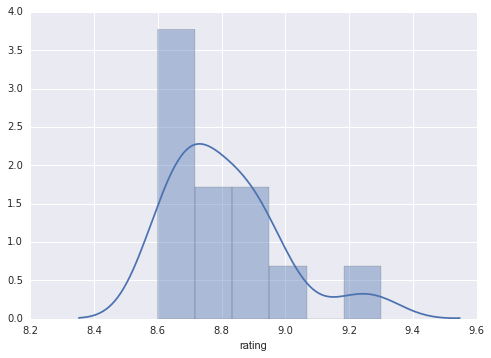

In [133]:
sns.distplot(df.rating)

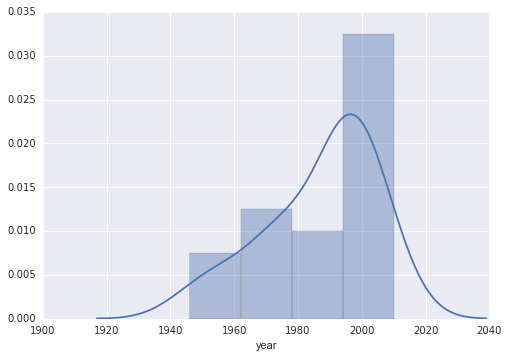

In [137]:
df.year.plot(kind='hist', style=)
# sns.distplot(df.year)

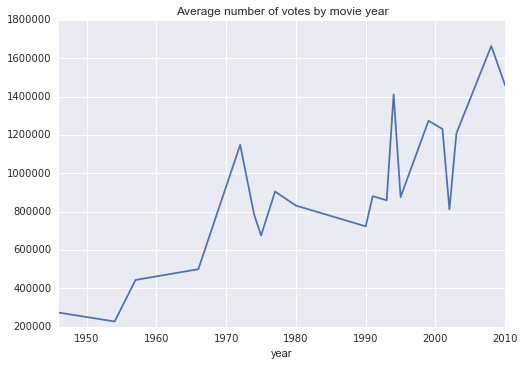

In [199]:
df.groupby('year').num_votes.mean().plot(title='Average number of votes by movie year')

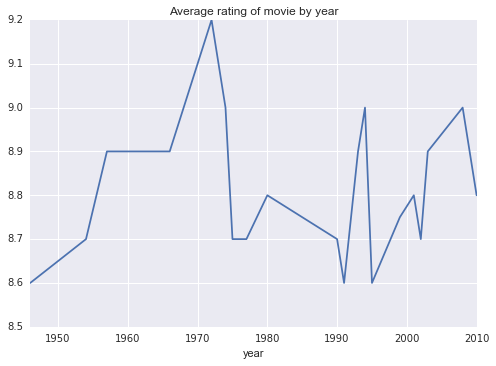

In [201]:
df.groupby('year').rating.mean().plot(title='Average rating of movie by year')

In [182]:
df.head(1)

,num_votes,rating,tconst,title,year,review_1,review_2,review_3,review_4,review_5,...,review_16,review_17,review_18,review_19,review_20,review_21,review_22,review_23,review_24,review_25
0,1678989,9.3,tt0111161,The Shawshank Redemption,1994,Why do I want to write the 234th comment on Th...,Can Hollywood usually creating things for ente...,I have never seen such an amazing film since I...,In its Oscar year Shawshank Redemption written...,The reason I became a member of this database ...,...,Yes there are SPOILERS hereThis film has had s...,We have all see movies comedies action and dra...,This touching and heart warming film is the mo...,Probably yes acting was good plot brilliant I ...,In recent years the IMDB top 250 movies has ha...,When I saw that the Shawshank Redemption was 1...,A friend of mine listed The Shawshank Redempti...,I was a little surprised at first to see this ...,I made my account on IMDb Just to Rate this mo...,I first saw this film like many others by chan...


## Part 5: Build the Decision Tree

#### 1. What is our target attribute? 

Movie Ratings.

#### 2. Prepare the data and define the training set

In [141]:
X = df.ix[:,5:]
print X.shape
X.head()

(25, 25)


,review_1,review_2,review_3,review_4,review_5,review_6,review_7,review_8,review_9,review_10,...,review_16,review_17,review_18,review_19,review_20,review_21,review_22,review_23,review_24,review_25
0,Why do I want to write the 234th comment on Th...,Can Hollywood usually creating things for ente...,I have never seen such an amazing film since I...,In its Oscar year Shawshank Redemption written...,The reason I became a member of this database ...,I believe that this film is the best story eve...,One of my all time favorites Shawshank Redempt...,One of the finest films made in recent years I...,Misery and Stand By Me were the best adaptatio...,The Shawshank Redemption is without a doubt on...,...,Yes there are SPOILERS hereThis film has had s...,We have all see movies comedies action and dra...,This touching and heart warming film is the mo...,Probably yes acting was good plot brilliant I ...,In recent years the IMDB top 250 movies has ha...,When I saw that the Shawshank Redemption was 1...,A friend of mine listed The Shawshank Redempti...,I was a little surprised at first to see this ...,I made my account on IMDb Just to Rate this mo...,I first saw this film like many others by chan...
1,Rather than concentrating on everything that i...,This is by far the best movie ever to give a p...,The Godfather is one of the few films in which...,This movie is strong good script great ca...,The Godfather is one of the very few films tha...,This is a masterpiece A timeless masterpiece I...,This must rank as the best film along with par...,The Godfather is the pinnacle of flawless film...,I love this movie and all of the GF movies I s...,The godfather trilogy is an exclusive set of m...,...,Tell me a movie that is more famous than this ...,I can remember when I first watched The Godfat...,Michael Corleone returns home from the war for...,Some people have called this one of the best m...,The Godfather is an extravaganza nigh flawless...,One thing thats a bit annoying when seeing The...,First I have to say that it is very difficult ...,Spoilers AheadI am not a big fan of the sequel...,Think epic novel crossed with Mafia speakImagi...,Marlon Brandos acting as the Godfather is subl...
2,This movie is way to be good to be labelled a ...,The original Godfather is a brilliant work It ...,You can count on one hand the movie sequels th...,The Godfather Part 2 is the finest sequel ever...,Coppolas masterpiece is rivaled only by The Go...,The Godfather Part II 1974Number 1 1974Top 3 ...,Series note It is almost unthinkable to watch ...,After seeing The Godfather and improving it as...,The Godfather Part Two is possibly the best fi...,Francis Coppola and Mario Puzo continue their ...,...,The Godfather Part II is a consummation of the...,Sequel to the original Godfather is slower mov...,OK Lets get real The Godfather is beyond excel...,The Godfather Part II hit theatres a couple of...,The sequel to The Godfather at times was just ...,This isnt quite as powerful as the first Godfa...,I have been forced to watch the Godfather tril...,In the movies sequels have always been difficu...,Godfather Two is Coppolas movieand he had no i...,Nino Rotas musical score plays an even greater...
3,Weve been subjected to enormous amounts of hyp...,Christopher Nolans second bundle of joy The Da...,I had the honor of watching TDK during a scree...,I used to leave a theatre after seeing a highl...,I must say I was excited for this movie since ...,I thought Batman Begins was a very well concei...,Batman has always been my favourite superhero ...,Synopsis Bruce WayneBatman Christian Bale cont...,I got to see The Dark Knight on Wednesday nigh...,I think the big questionor the question everyo...,...,Im just gonna start off by saying I LOVE this ...,This was the most hyped movie of the year and ...,The Dark Knight maintained the intensity and o...,Whatever else it may be The Dark Knight Christ...,Well here it is one of the most anticipated mo...,Obviously Christopher Nolan was tryi

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(X)
X = pd.DataFrame(cvec.transform(X).todense())

In [153]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [180]:
y = df.rating.values.astype(int)
print len(y)
print y[:5]

25
[9 9 9 9 8]


In [173]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1987)

#### 2. Train the Model

In [174]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

#### 3. Set up test data and test the model

In [203]:
print dt.score(X_test, y_test)

0.888888888889


#### 5. Check the results

In [176]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_validation import cross_val_score

In [204]:
y_pred = dt.predict(X_test)
accuracy_score(y_test, y_pred)

0.88888888888888884

In [202]:
scores = cross_val_score(dt, X, y, cv=5)
print 'All Scores', scores
print 'Average Score', np.mean(scores)

All Scores [ 0.83333333  0.8         0.8         0.8         1.        ]
Average Score 0.846666666667


In [181]:
print confusion_matrix(y_test, y_pred)

[[8 0]
 [1 0]]


#### 6. What is overfitting and how are we at risk? 

Overfitting is when the model has l